# Store sales predictions



In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression

# let the notebook know where to find the data
os.chdir("C:/Users/benla/Desktop/store_sales_forecasting")



In [16]:
# first we will load the data
df_train = pd.read_csv("data/raw/train.csv", header=0)

# check out the shape and head of the dataframe
print(f"df_train shape: {df_train.shape}")
print(f"df_train head:\n{df_train.head()}")

df_train shape: (3000888, 6)
df_train head:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


The next step is to perform EDA on the data

In [ ]:
# after the initial basic EDA we will make a baseline model to see how well it can fit the data
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True) # makes family into one hot encoding 
y = df_train['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 0.56
Test accuracy: 0.61


In [28]:
# both the testing and training accuracy of linear regression is low
# indicates that either data is non linear, not enough features, or model is too simple

# first test how performance changes with more features
x.head()



,store_nbr,onpromotion,month,day_of_week,is_weekend,store_avg_sales,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1,0,1,1,0,254.534889,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,1,1,0,254.534889,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,1,1,0,254.534889,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,1,1,0,254.534889,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,1,1,0,254.534889,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# first we just see how far awar from the actual values the model is
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r1 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.1f}") # this is very large, given that the average sales is around 360
print(f"RMSE: {rmse:.1f}") # this is also large, which means we are getting lots of large errors
print(f"R²: {r1:.2f}")
plt.scatter(y_test, y_pred, alpha=-1.5) # plot the predictions and the actual values
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# in conclusion, it seems that the variance in values of the data is very high, making MAE very large.
# Additionally, RMSE is also very large, meaning that there are many outliers
# on way of potentially combating this would be to log the sales values.
# we should also experiment with adding more features to the model, and making other models as well.

"""TODO:
0. log transform the sales values to see if it helps with the model
1. add more features to the model, such as store average sales, family average sales, etc
2. add month, day of week, and is_weekend
"""


# NEXT TIME DO RESEARCH ON THE DIFFERENT WAYS WE EVALUTATE MODELS LIKE ROC CURVES ETC.

# probably should add average store sales to the feature list

# how do i figure out which features should be added, given the context? is there something like a set checklist that can let me know if i am missing features?

# should I be adding the features first, or should i be making a really simple model first and then adding features later? how would i go about doing that? should i like add one feature at at ime, or add a bunch?

# how do i know which features are important? how do i know which features can be ignored/taken out?

# is the list of features that I should have changing with every model?

In [19]:
# now I will try to add some features to the model, and see how the performance changes
df_train['date'] = pd.to_datetime(df_train['date']) # format it to the right date
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype(int) # 1 if weekend, 0 if not

# also include features like store average sales, family average sales, etc
df_train['store_avg_sales'] = df_train.groupby('store_nbr')['sales'].transform('mean')

print(df_train.head())

print(df_train.info())

   id       date  store_nbr      family  sales  onpromotion  month  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0      1   
1   1 2013-01-01          1   BABY CARE    0.0            0      1   
2   2 2013-01-01          1      BEAUTY    0.0            0      1   
3   3 2013-01-01          1   BEVERAGES    0.0            0      1   
4   4 2013-01-01          1       BOOKS    0.0            0      1   

   day_of_week  is_weekend  store_avg_sales  
0            1           0       254.534889  
1            1           0       254.534889  
2            1           0       254.534889  
3            1           0       254.534889  
4            1           0       254.534889  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   

Model accuracy: 0.84
Train accuracy: 0.81
Test accuracy: 0.84
MAE: 215.39
RMSE: 546.63
R²: 0.84


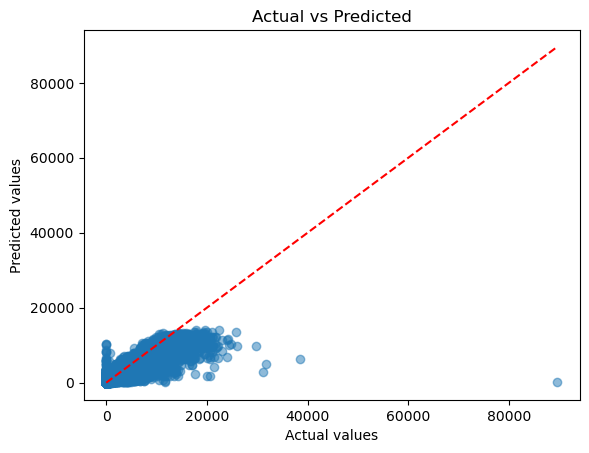

In [20]:
# now we just basically run the same model while including the new features
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True)
y = df_train['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=305
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# once we have the model, we now want to evaluate it
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}") # this is very large, given that the average sales is around 360
print(f"RMSE: {rmse:.2f}") # this is also large, which means we are getting lots of large errors
print(f"R²: {r2:.2f}")
plt.scatter(y_test, y_pred, alpha=0.5) # plot the predictions and the actual values
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show() 

In [ ]:
# new we will start on building a new model with the new features to see if we can improve the peformance

# the first thing that we should build is probably the linear regression model
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True)
y = df_train['sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

# now make a model
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

# Performance of linear regression is not great

# so i should first make a linear regression model, and then see how well it performs

0.6147366594183296